In [1]:
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import struct
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Abort

In [305]:
os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/')

['LERFUJI_2024-10-17_01-05-01.npz',
 'LERFUJI_2024-10-10_22-11-36.npz',
 'LERFUJI_2024-10-15_11-30-38.npz',
 'LERFUJI_2024-10-10_21-29-54.npz',
 'LERFUJI_2024-10-13_11-42-07.npz',
 'LERFUJI_2024-10-17_09-02-58.npz',
 'LERFUJI_2024-10-13_12-47-29.npz',
 'LERFUJI_2024-10-16_01-06-09.npz',
 'LERFUJI_2024-10-14_00-14-04.npz',
 'LERFUJI_2024-10-15_21-28-08.npz',
 'LERFUJI_2024-10-16_08-57-48.npz',
 'LERFUJI_2024-10-13_14-34-59.npz',
 'LERFUJI_2024-10-14_11-04-39.npz',
 'LERFUJI_2024-10-17_00-58-37.npz',
 'LERFUJI_2024-10-16_07-17-11.npz',
 'LERFUJI_2024-10-15_23-43-13.npz',
 'LERFUJI_2024-10-14_00-35-00.npz',
 'LERFUJI_2024-10-15_20-22-59.npz',
 'LERFUJI_2024-10-15_10-14-14.npz',
 'LERFUJI_2024-10-10_21-12-23.npz',
 'LERFUJI_2024-10-16_04-52-14.npz',
 'LERFUJI_2024-10-15_20-56-49.npz',
 'LERFUJI_2024-10-13_00-10-19.npz',
 'LERFUJI_2024-10-14_01-44-58.npz',
 'LERFUJI_2024-10-15_19-08-53.npz',
 'LERFUJI_2024-10-15_10-21-29.npz',
 'LERFUJI_2024-10-15_08-37-16.npz',
 'LERFUJI_2024-10-13_03-50-4

In [2]:
def make_mastdplot(filename):
    npz_kw = np.load('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/'+filename,allow_pickle=True)
    X_sum=npz_kw['X_sum']
    X_delta=npz_kw['X_delta']
    Y_sum=npz_kw['Y_sum']
    Y_delta=npz_kw['Y_delta']
    X_pos=npz_kw['X_Pos']
    X_ma=npz_kw['X_MA']
    X_std=npz_kw['X_STD']
    #X_valid=npz_kw['X_valid']
    Y_pos=npz_kw['Y_Pos']
    Y_ma=npz_kw['Y_MA']
    Y_std=npz_kw['Y_STD']
    #Y_valid=npz_kw['Y_valid']
    #iv=npz_kw['Injection_Veto']
    abortflag=npz_kw['AbortFlag']


    if filename=="LERFUJI_2024-10-16_08-57-48.npz":
        X_std=np.zeros(len(X_pos))
        X_delta=np.zeros(len(X_sum))
    if filename=="LERFUJI_2024-10-15_19-08-53.npz":
        X_sum=np.zeros(len(X_delta))
    if filename=="LERFUJI_2024-10-16_01-58-36.npz":
        Y_sum=np.zeros(len(Y_delta))
    timesteps=np.arange(len(X_pos))/254.5
    timesteps=timesteps-timesteps[-1]

    timesteps2=np.arange(len(X_sum))/509
    timesteps2=timesteps2-timesteps2[-1]

    ##################    


    df = pd.DataFrame({'x':timesteps2,'X_sum':X_sum,'X_delta':X_delta})
    threshold=2000
    # 条件に従って 'result' を計算
    df['result'] = np.where(df['X_sum'] > threshold, df['X_delta'] / df['X_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff'] = df['result'] - df['result'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff'] = np.where(abs(df['result_diff']) > 0.4, np.nan, df['result_diff'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff'] = np.where(df['X_sum'] <= threshold, np.nan, df['result_diff'])
    df['result_interp']=df['result_diff'].interpolate(method='spline',order=2)
    #------------------
    signal = df['result_interp'].values
    signal=signal[~np.isnan(signal)]
    if len(signal)==0:
        return
    fft_result = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal),d=1/509)
    # 正の周波数部分のみ抽出
    positive_freqs = fft_freqs[:len(fft_freqs)//2]
    positive_fft = np.abs(fft_result[:len(fft_result)//2])
    #-------------------
    df=df.dropna()
    # 移動平均と移動標準偏差を計算
    df['result_ma500'] = df['result_diff'].rolling(window=500).mean()
    df['result_ma10000'] = df['result_diff'].rolling(window=10000).mean()
    # window=500の移動平均を17行下にシフト
    df['result_ma500_shifted'] = df['result_ma500'].shift(17)
    # 二つの移動平均の差の絶対値を計算
    df['result_ma_diff'] = abs(df['result_ma500_shifted'] - df['result_ma10000'])
    df['result_std500'] = df['result_diff'].rolling(window=500).std()
    df['std_shifted']=df['result_std500'].shift(500)

    if len(df)==0:
        return
    df['x']=df['x']-df['x'].iloc[-1]

    fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True,figsize=(16,6))
    ax1.set_title(f'{filename}')
    #ax1.plot(timesteps,X_pos,label='X position')
    #ax1.plot(timesteps,X_ma/500,label='MA/500')
    #ax1.plot(timesteps,X_std/500,label='STD/500')
    #ax1.plot(timesteps,iv,label='injection veto')
    #ax1.plot(timesteps,abortflag/2,label='AbortFlag')

    ax1.plot(df['x'],df['result_diff'],label='X Position')
    ax1.plot(df['x'], df['result_ma_diff']*20, label='MA')
    ax1.plot(df['x'], df['std_shifted']*20, label='STD')
    
    ax1.set_ylim(-0.2,0.6)
    ax1.grid()
    ax1.set_ylabel('X position (a.u.)')
    ax1.legend()

    ####################
    
    #ax2.plot(timesteps,Y_pos,label='Y position')
    #ax2.plot(timesteps,Y_ma/500,label='MA/500')
    #ax2.plot(timesteps,Y_std/500,label='STD/500')
    #ax2.plot(timesteps,iv,label='injection veto')
    #ax2.plot(timesteps,abortflag/2,label='AbortFlag')

    
    df = pd.DataFrame({'x':timesteps2,'Y_sum':Y_sum,'Y_delta':Y_delta})
    threshold=4000
    # 条件に従って 'result' を計算
    df['result'] = np.where(df['Y_sum'] > threshold, df['Y_delta'] / df['Y_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff'] = df['result'] - df['result'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff'] = np.where(abs(df['result_diff']) > 0.4, np.nan, df['result_diff'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff'] = np.where(df['Y_sum'] <= threshold, np.nan, df['result_diff'])
    df['result_interp']=df['result_diff'].interpolate(method='spline',order=2)
    #------------------
    signaly = df['result_interp'].values
    signaly=signaly[~np.isnan(signaly)]
    if len(signaly)==0:
        return
    fft_resulty = np.fft.fft(signaly)
    fft_freqsy = np.fft.fftfreq(len(signaly),d=1/509)
    # 正の周波数部分のみ抽出
    positive_freqsy = fft_freqsy[:len(fft_freqsy)//2]
    positive_ffty = np.abs(fft_resulty[:len(fft_resulty)//2])
    #-------------------
    df=df.dropna()
    # 移動平均と移動標準偏差を計算
    df['result_ma500'] = df['result_diff'].rolling(window=500).mean()
    df['result_ma10000'] = df['result_diff'].rolling(window=10000).mean()
    # window=500の移動平均を17行下にシフト
    df['result_ma500_shifted'] = df['result_ma500'].shift(17)
    # 二つの移動平均の差の絶対値を計算
    df['result_ma_diff'] = abs(df['result_ma500_shifted'] - df['result_ma10000'])
    df['result_std500'] = df['result_diff'].rolling(window=500).std()
    df['std_shifted']=df['result_std500'].shift(500)

    if len(df)==0:
        return

    df['x']=df['x']-df['x'].iloc[-1]

    ax2.plot(df['x'],df['result_diff'],label='Y Position')
    ax2.plot(df['x'], df['result_ma_diff']*20, label='MA')
    ax2.plot(df['x'], df['std_shifted']*20, label='STD')

    

    ax2.grid()
    ax2.legend()
    ax2.set_ylim(-0.2,0.6)
    ax2.set_ylabel("Y position (a.u.)")
    plt.xlim(-800,0)
    ax2.set_xlabel("Time (us)")
    plt.savefig(f'abort_picture/{filename[8:-4]}.png',dpi=100)
    #plt.show()
    plt.close()

    plt.figure(figsize=(16,4))
    plt.plot(positive_freqs, positive_fft)
    plt.title('FFT of Xpos')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.xscale('log')
    plt.savefig(f'abort_picture/{filename[8:-4]}_fft.png',dpi=100)
    plt.close()

    window_size = 5120*5
    step_size = 2560
    signal_length = len(signal)
    fft_results = []
    # スライディングウィンドウでFFTを計算
    for start in range(0, signal_length - window_size + 1, step_size):
        windowed_signal = signal[start:start + window_size]
        fft_result = np.fft.fft(windowed_signal)
        # 正の周波数のみを取得
        positive_freqs = np.abs(fft_result[:window_size // 2])
        fft_results.append(positive_freqs)
    # 結果を配列に変換
    fft_results = np.array(fft_results)
    """
    fft_results = np.log(fft_results + 1e-10)
    # ヒートマップのプロット
    plt.figure(figsize=(12, 6))
    sns.heatmap(fft_results, cmap='viridis', cbar=True,vmin=0,vmax=4)
    plt.gca().set_aspect('auto') 
    plt.title('FFT Heatmap Xpos')
    plt.xlabel('Frequency Bins')
    plt.ylabel('Window Index')
    plt.savefig(f'abort_picture/{filename[8:-4]}_fftheatmapx.png',dpi=100)
    plt.close()

    plt.figure(figsize=(16,4))
    plt.plot(positive_freqsy, positive_ffty)
    plt.title('FFT of Ypos')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.xscale('log')
    plt.savefig(f'abort_picture/{filename[8:-4]}_ffty.png',dpi=100)
    plt.close()
    """
    # X, Y, Z 軸の値を作成
    X = np.arange(fft_results.shape[1])  # 周波数ビン (横軸)
    Y = np.arange(fft_results.shape[0])  # ウィンドウインデックス (縦軸)
    X, Y = np.meshgrid(X, Y)  # メッシュグリッドを作成
    Z = fft_results  # Z軸（振幅）はログスケールのFFT結果
    # 三次元プロットの設定
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    # 3Dの表面プロット
    surf = ax.plot_surface(X, Y, Z, cmap='terrain',vmin=0,vmax=10)
    # カラーバーの追加
    fig.colorbar(surf)
    # ラベル設定
    ax.set_title('FFT 3D Plot Xpos')
    ax.set_xlabel('Frequency Bins')
    ax.set_ylabel('Window Index')
    ax.set_zlabel('Amplitude')
    ax.set_zlim(0,100)
    # プロット表示
    plt.savefig(f'abort_picture/{filename[8:-4]}_fft3Dx.png',dpi=100)
    plt.close()
    
    window_size = 5120*2
    step_size = 2560
    signal_length = len(signaly)
    fft_results = []
    # スライディングウィンドウでFFTを計算
    for start in range(0, signal_length - window_size + 1, step_size):
        windowed_signal = signaly[start:start + window_size]
        fft_result = np.fft.fft(windowed_signal)
        # 正の周波数のみを取得
        positive_freqs = np.abs(fft_result[:window_size // 2])
        fft_results.append(positive_freqs)
    # 結果を配列に変換
    fft_results = np.array(fft_results)
    fft_results = np.log(fft_results + 1e-10)
    # ヒートマップのプロット
    plt.figure(figsize=(12, 6))
    sns.heatmap(fft_results, cmap='viridis', cbar=True,vmin=0,vmax=4)
    plt.gca().set_aspect('auto') 
    plt.title('FFT Heatmap Ypos')
    plt.xlabel('Frequency Bins')
    plt.ylabel('Window Index')
    plt.savefig(f'abort_picture/{filename[8:-4]}_fftheatmapy.png',dpi=100)
    plt.close()
    return df

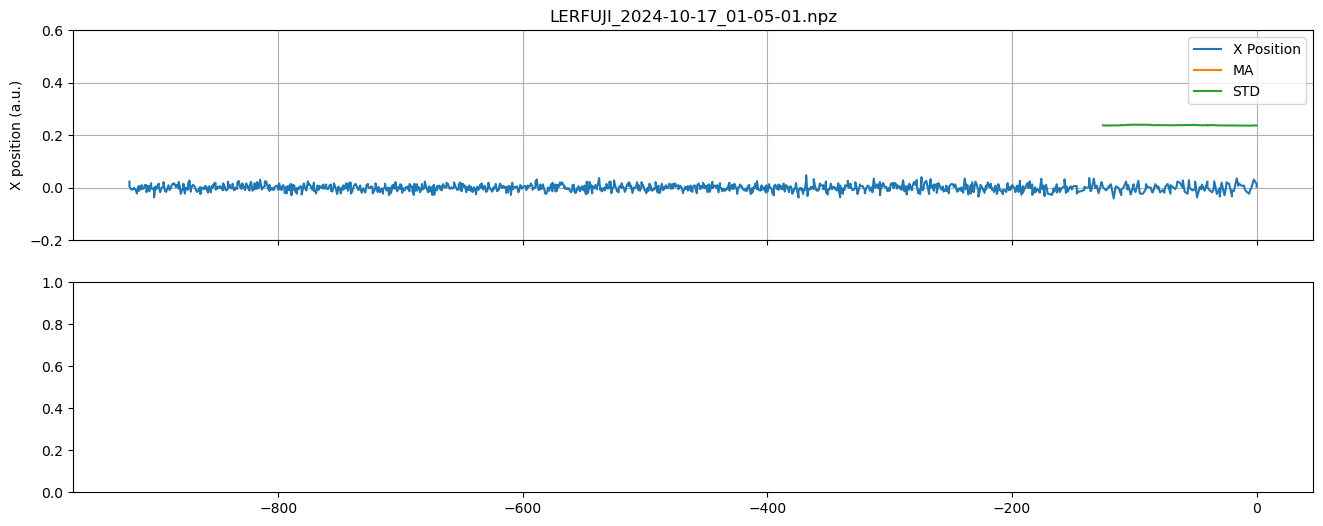

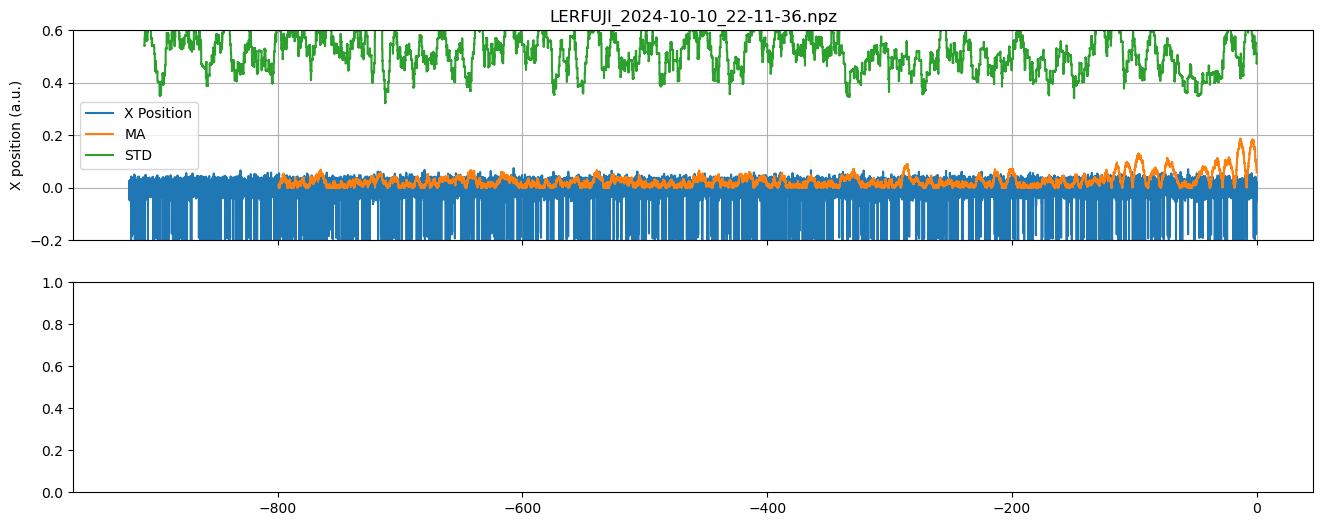

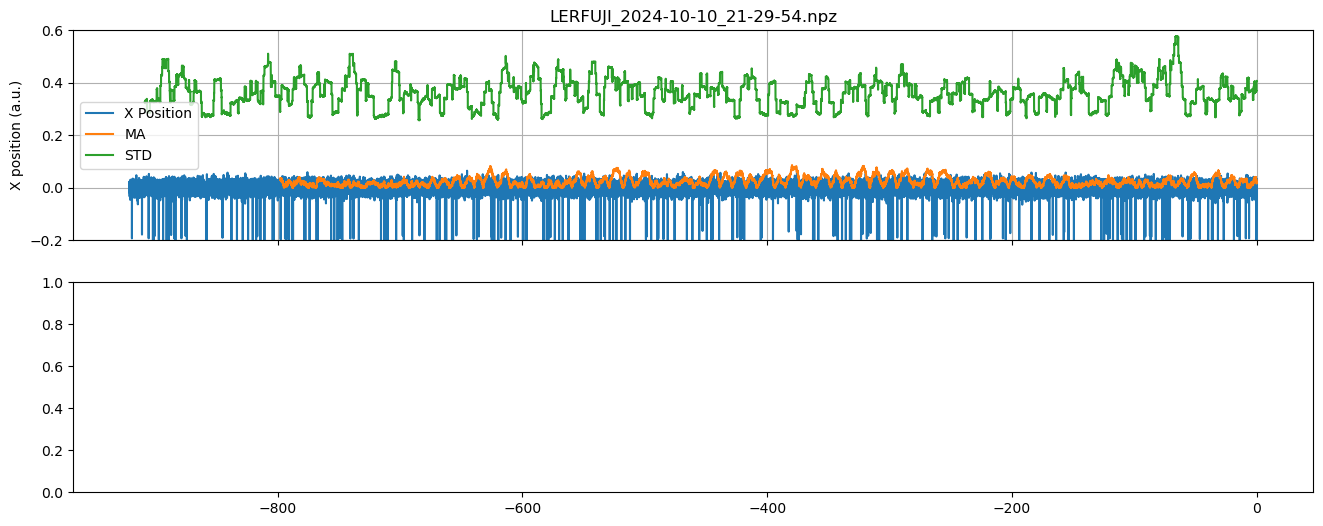

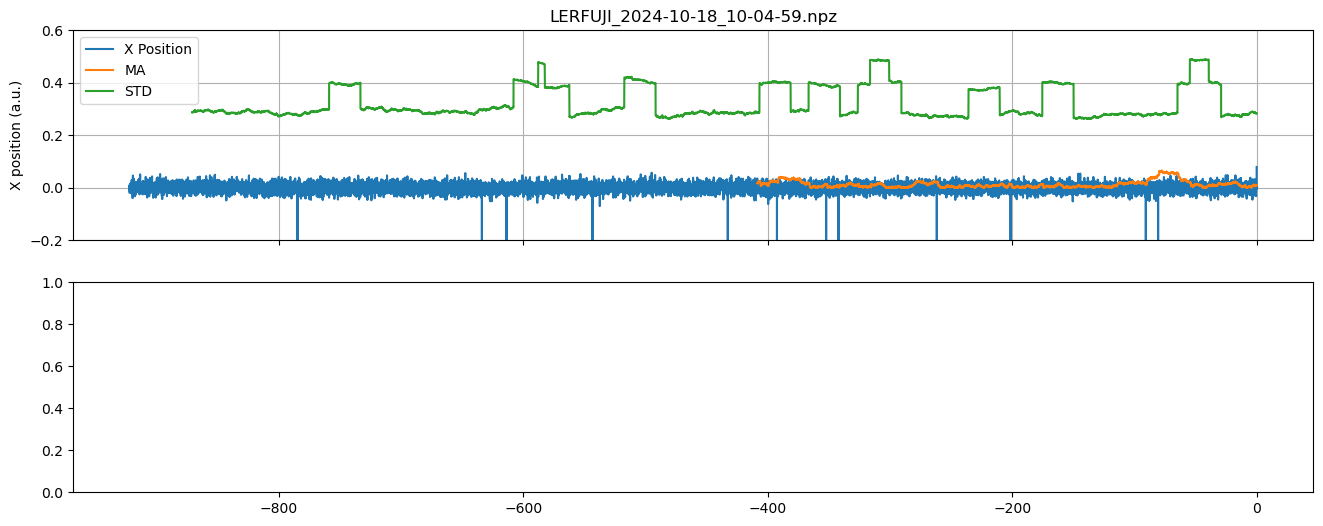

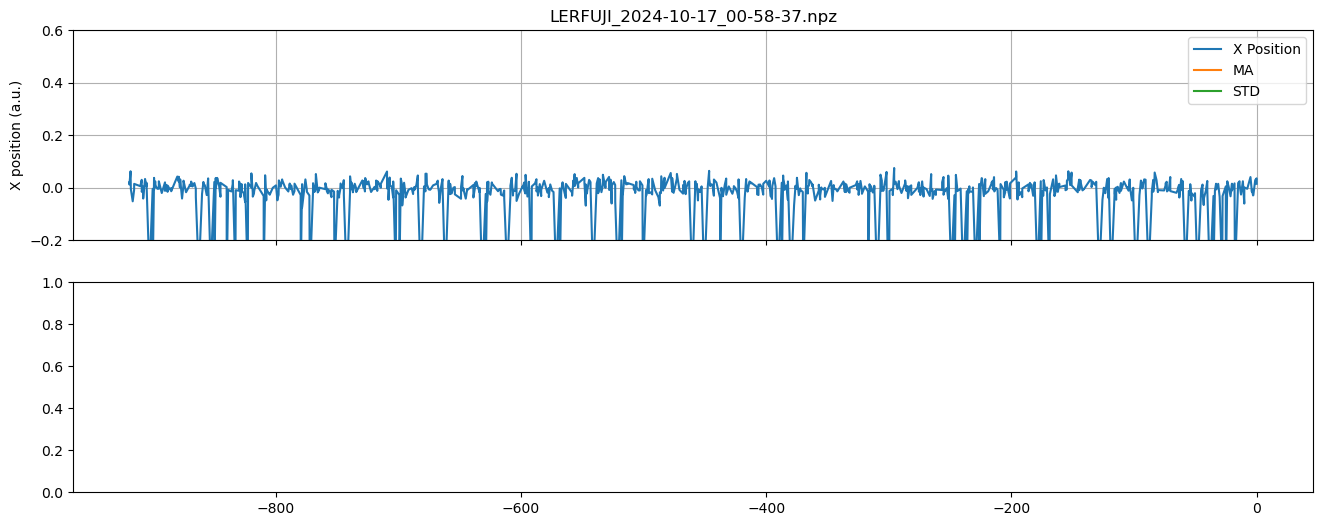

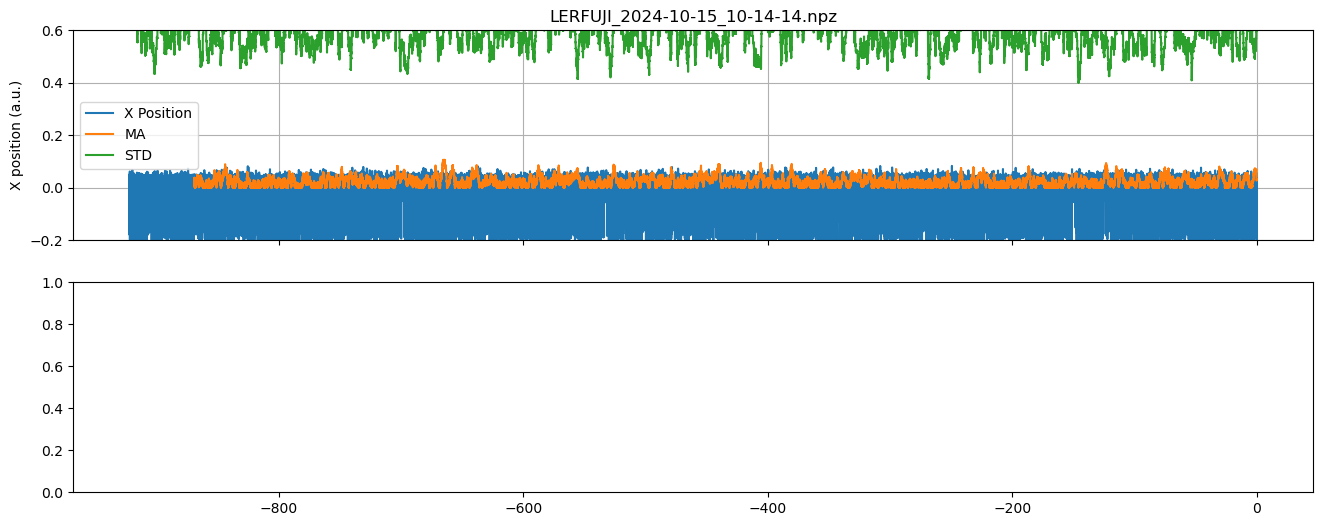

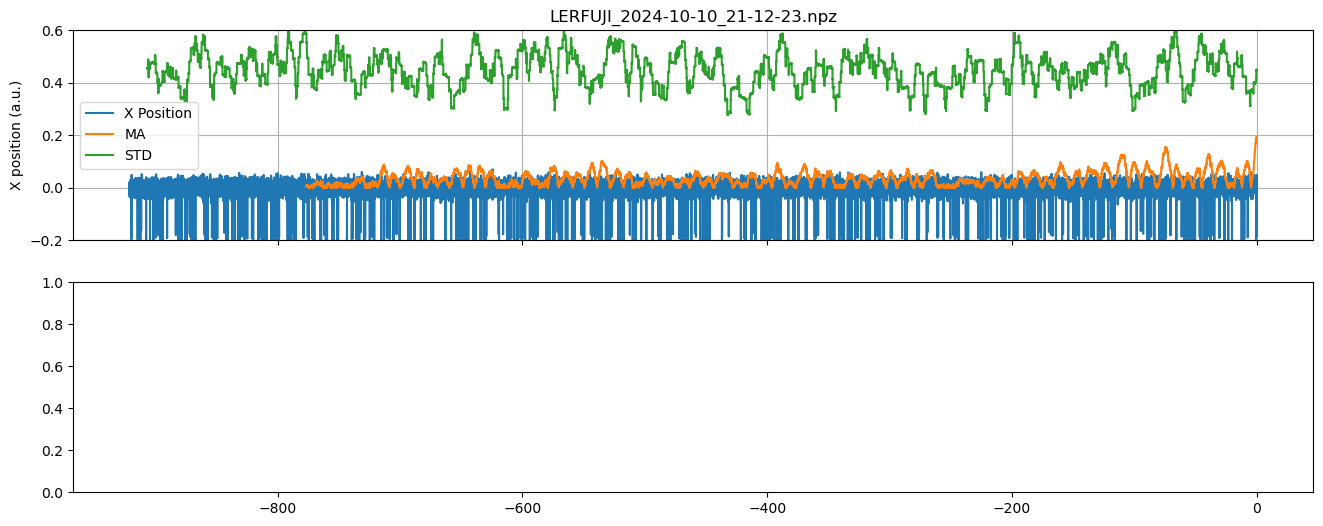

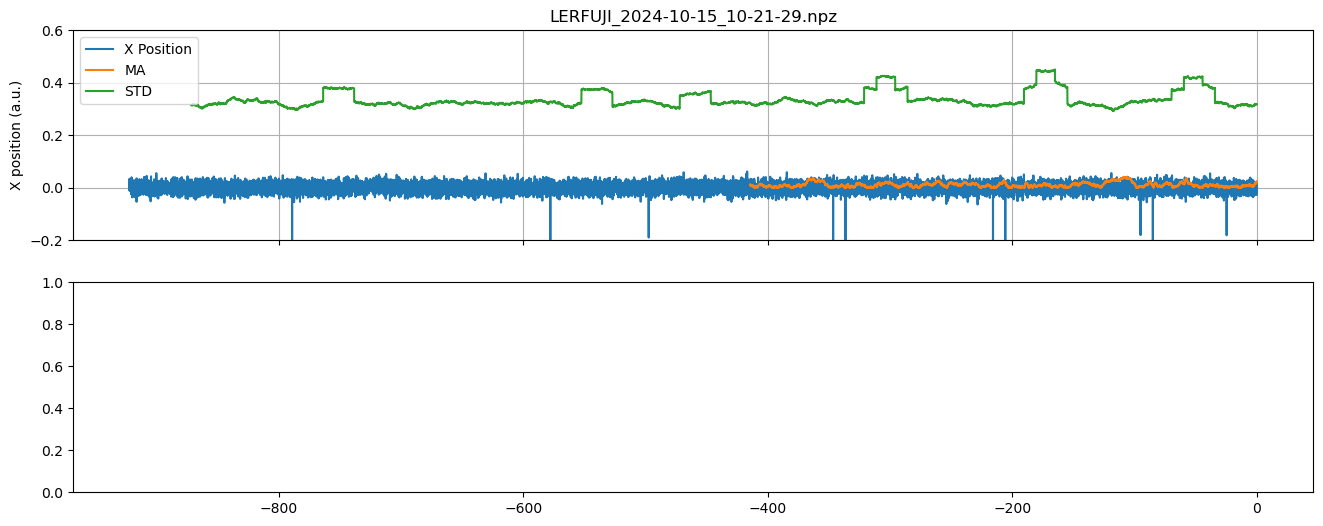

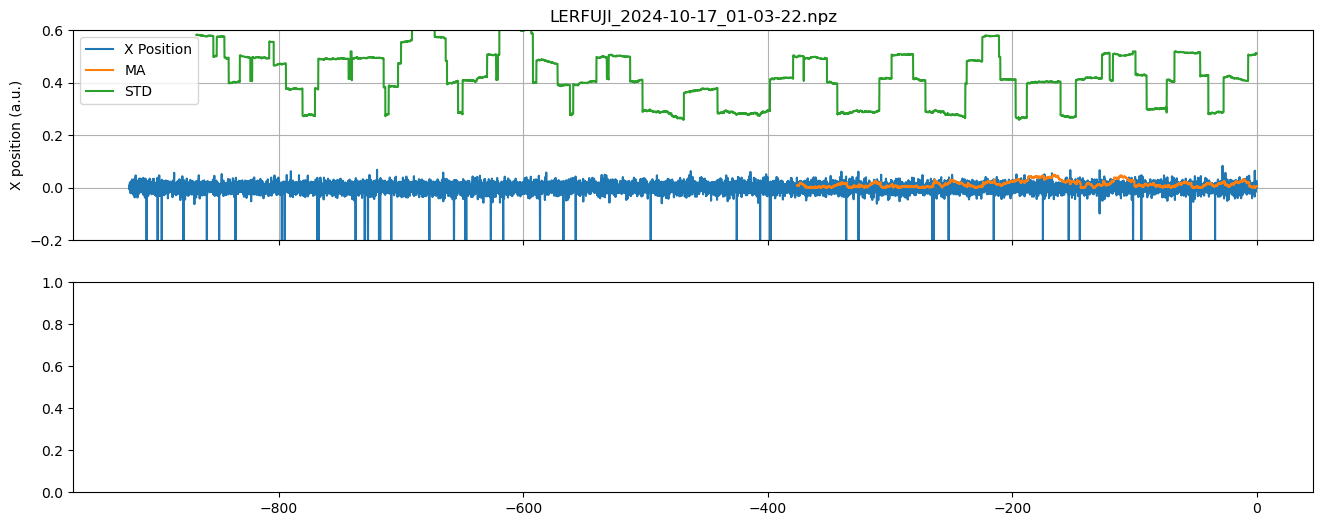

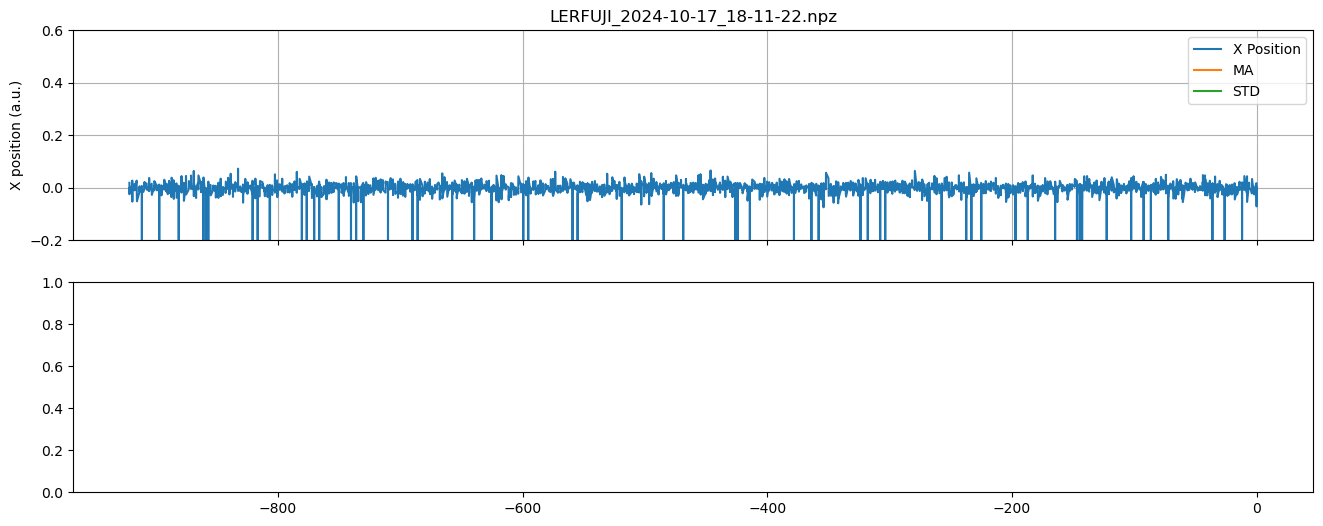

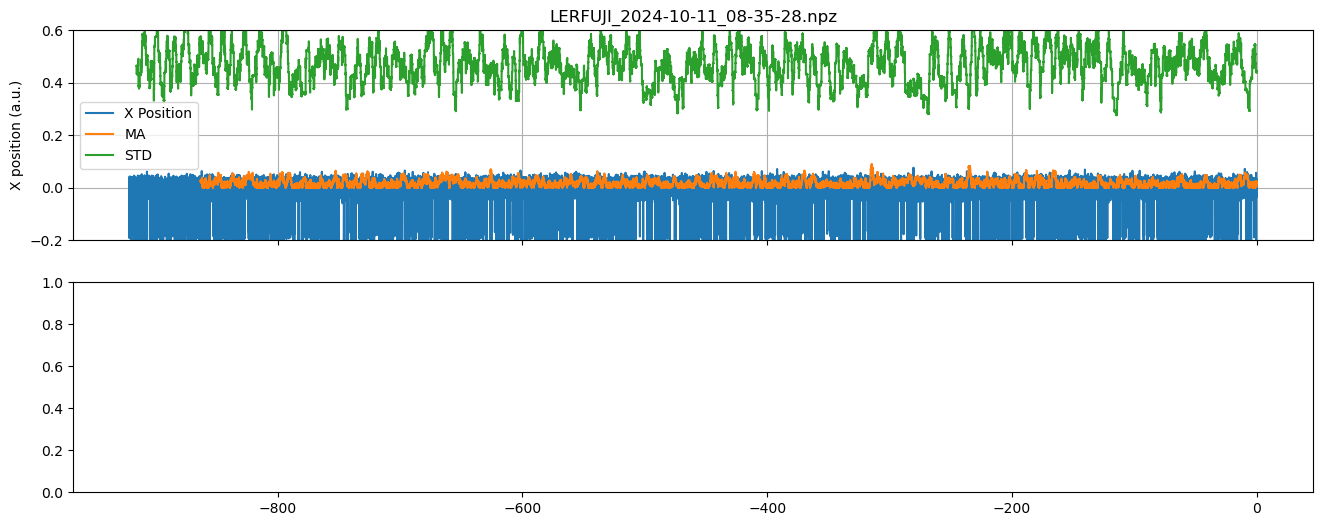

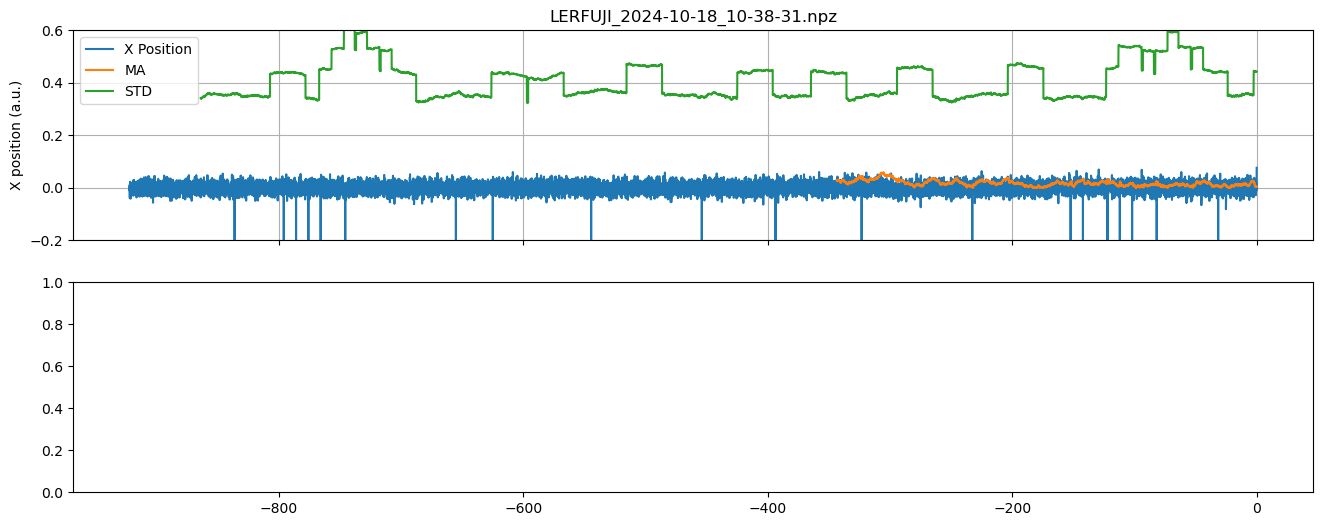

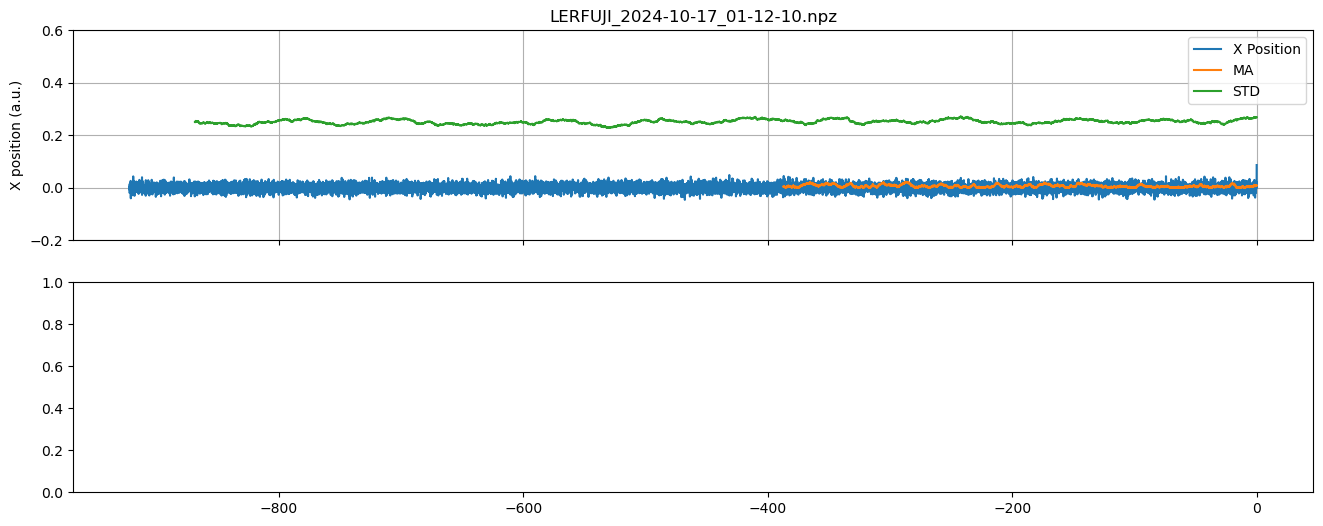

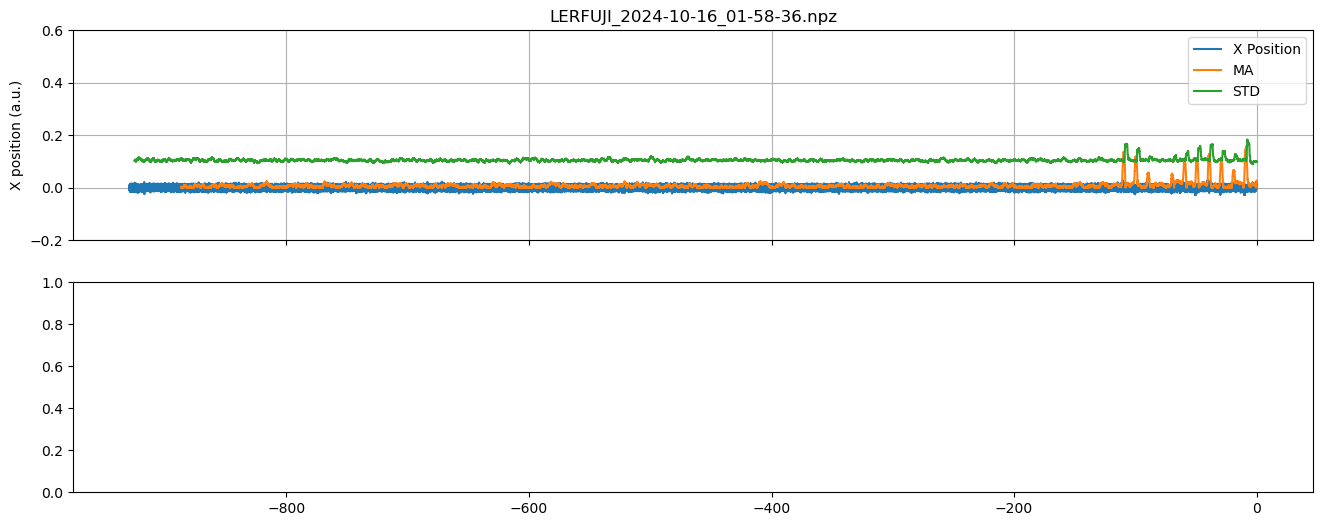

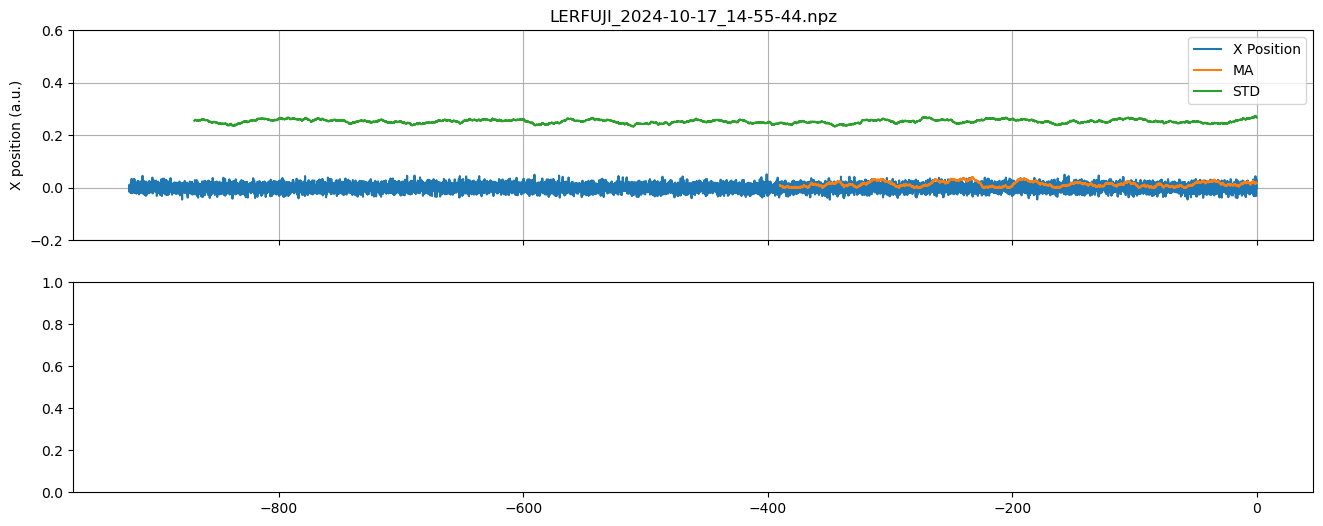

In [3]:
for i in os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/'):
    make_mastdplot(i)

In [207]:
df

,x,X_sum,X_delta,result,result_diff,result_ma500,result_ma10000,result_ma500_shifted,result_ma_diff,result_std500,std_shifted
51201,-929.442043,8412,-2220,-0.263909,0.006736,-0.263909,-0.263909,NaN,NaN,NaN,NaN
51203,-929.438114,7740,-2164,-0.279587,-0.009107,-0.271748,-0.271748,NaN,NaN,0.011086,NaN
51205,-929.434185,9084,-2516,-0.276970,-0.005207,-0.273489,-0.273489,NaN,NaN,0.008399,NaN
51207,-929.430255,7972,-2124,-0.266433,0.002081,-0.271725,-0.271725,NaN,NaN,0.007712,NaN
51209,-929.426326,7828,-2156,-0.275422,0.008466,-0.272464,-0.272464,NaN,NaN,0.006880,NaN
...,...,...,...,...,...,...,...,...,...,...,...
520634,-7.176817,6532,-2492,-0.381506,-0.107575,-0.400680,-0.271043,-0.399636,0.128593,0.028748,0.026380
520636,-7.172888,7276,-2892,-0.397471,-0.110590,-0.400759,-0.271058,-0.399719,0.128662,0.028703,0.026292
520639,-7.166994,8076,-3412,-0.422486,-0.134482,-0.400874,-0.271074,-0.399739,0.128665,0.028623,0.026274
520641,-7.163065,7356,-3020,-0.410549,-0.113514,-0.400999,-0.271089,-0.399805,0.128716,0.028578,0.026232


/tmp/ipykernel_3731348/3234357198.py:1: RuntimeWarning: divide by zero encountered in divide
  result=np.where(X_sum>500, X_delta/X_sum,0)


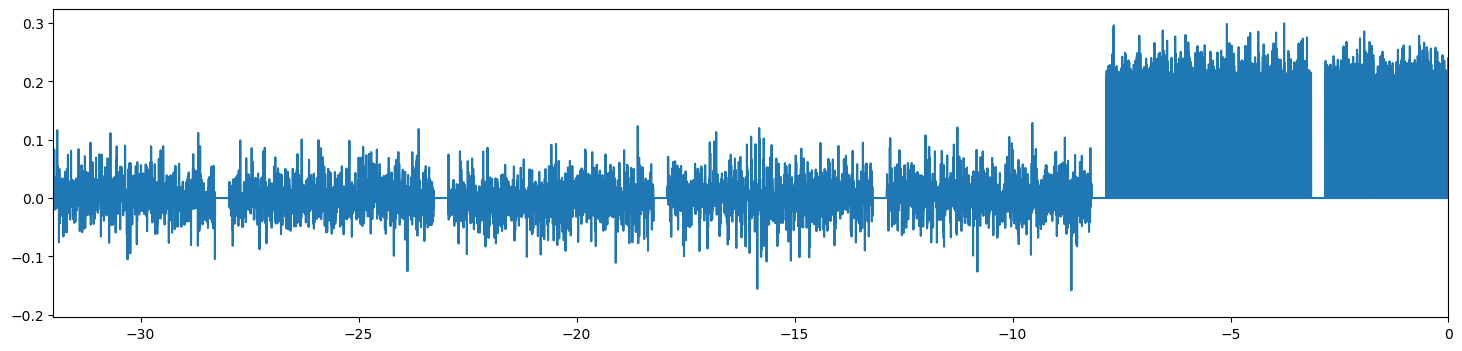

In [27]:
result=np.where(X_sum>500, X_delta/X_sum,0)
result=result[51200:]-result[:-51200]
timesteps=np.arange(len(result))/509
timesteps=timesteps-timesteps[-1]
plt.figure(figsize=(18,4))
plt.plot(timesteps,result)
plt.xlim(-32,0)
plt.show()

In [45]:
npz_kw = np.load('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/LERFUJI_2024-10-16_02-27-58.npz',allow_pickle=True)
X_sum=npz_kw['X_sum']
X_delta=npz_kw['X_delta']
Y_sum=npz_kw['Y_sum']
Y_delta=npz_kw['Y_delta']
X_pos=npz_kw['X_Pos']
X_ma=npz_kw['X_MA']
X_std=npz_kw['X_STD']
Y_pos=npz_kw['Y_Pos']
Y_ma=npz_kw['Y_MA']
Y_std=npz_kw['Y_STD']
iv=npz_kw['Injection_Veto']
abortflag=npz_kw['AbortFlag']

In [58]:
len(iv)

5462